- **Purpose:** Going through chapter 6
- **Date:** July 25, 2025

# 1. Library and data

In [35]:
# Load libraries
library(tidyverse)
library(readr)
install.packages("reticulate")
library(reticulate)
py_require("kagglehub")
kgh <- import("kagglehub")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [36]:
# Load dataset
path <- kgh$dataset_download("ashydv/advertising-dataset")
advert_df <- read_csv(paste0(path, "/advertising.csv"))
head(advert_df)

Rows: 200 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): TV, Radio, Newspaper, Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TV,Radio,Newspaper,Sales
<dbl>,<dbl>,<dbl>,<dbl>
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,12.0
151.5,41.3,58.5,16.5
180.8,10.8,58.4,17.9
8.7,48.9,75.0,7.2


# 2. Visualize synthetic data

In [37]:
# Seed
set.seed(41)

In [38]:
n <- 100
synth <- tibble(
  x=seq(from=1, to=30, length.out=n),
  y=log(x) + rnorm(n, 0, 0.2)
)
head(synth)

x,y
<dbl>,<dbl>
1.000000,0.2003409
1.292929,0.5146755
1.585859,0.6422766
1.878788,0.7293603
2.171717,0.8953753
2.464646,0.5861270


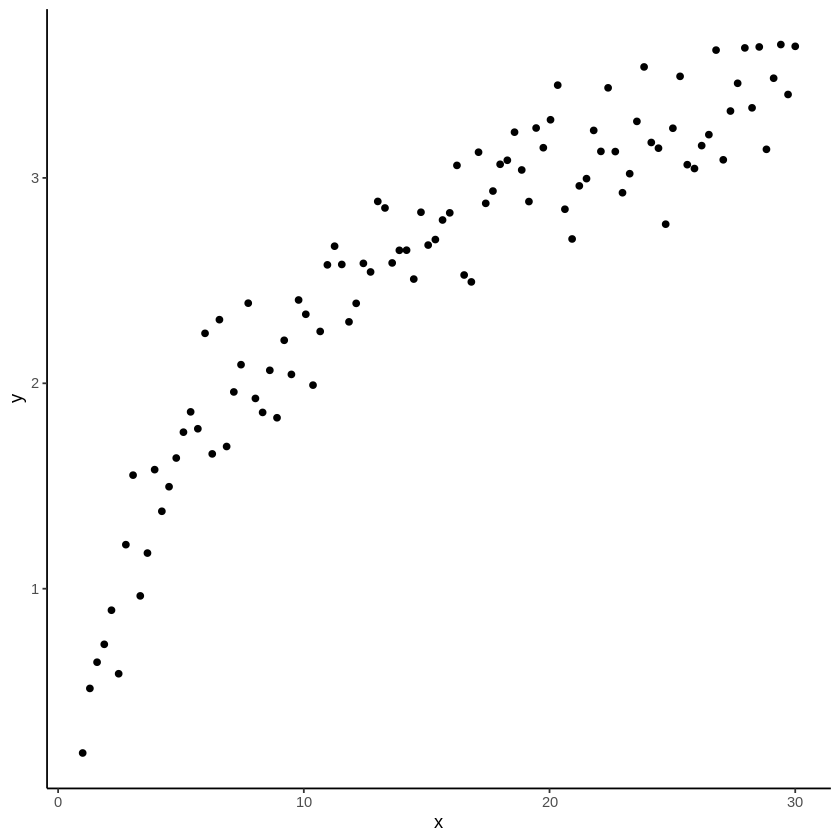

In [39]:
# Visualize the dataset
synth |>
  ggplot(aes(x, y)) +
    geom_point() +
    theme_classic()

`geom_smooth()` using formula = 'y ~ x'


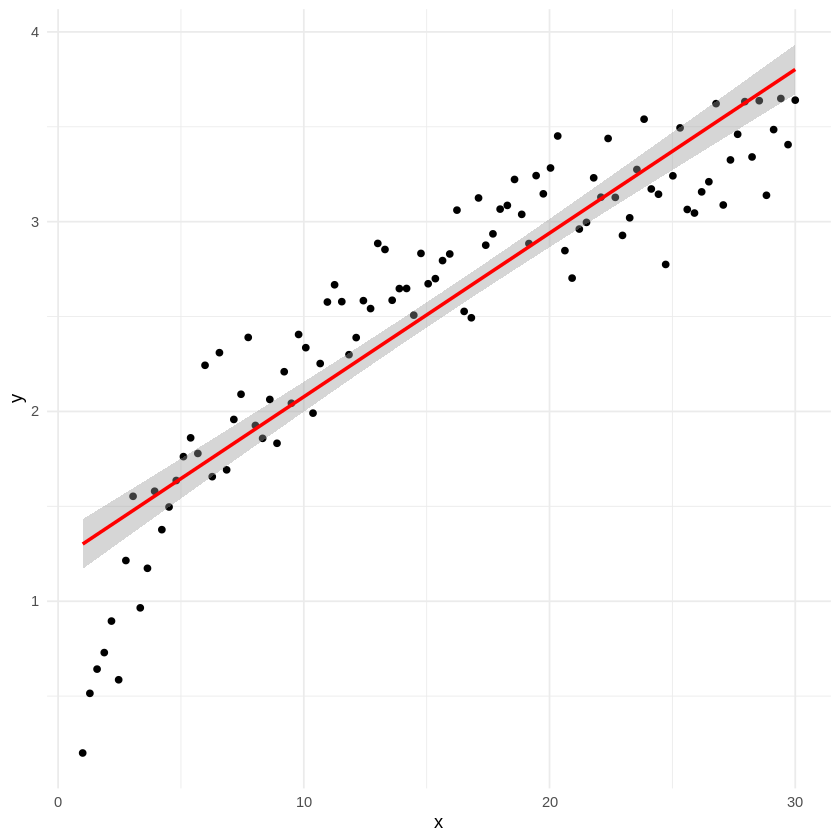

In [40]:
# linear model
naive_lm <- lm(y ~ x, data = synth)
naive_lm |>
  ggplot(aes(x, y)) +
  geom_point() +
  geom_smooth(method = "lm", color = "red") +
  theme_minimal()

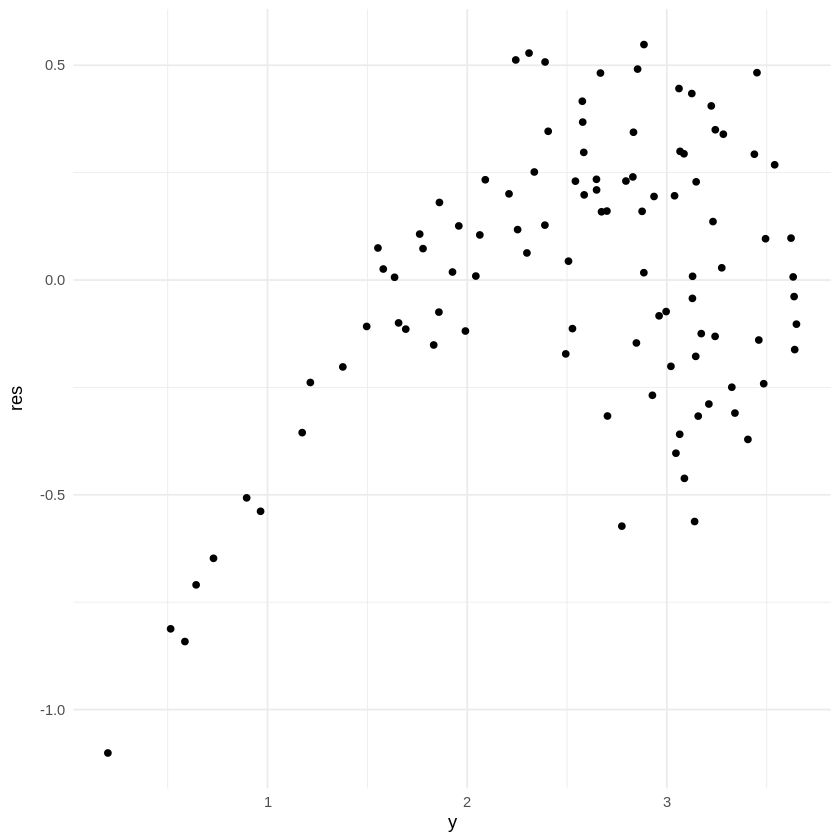

In [41]:
# Plotting residuals
synth |>
  mutate(res = naive_lm$residuals) |>
  ggplot() +
  geom_point(aes(y, res)) +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


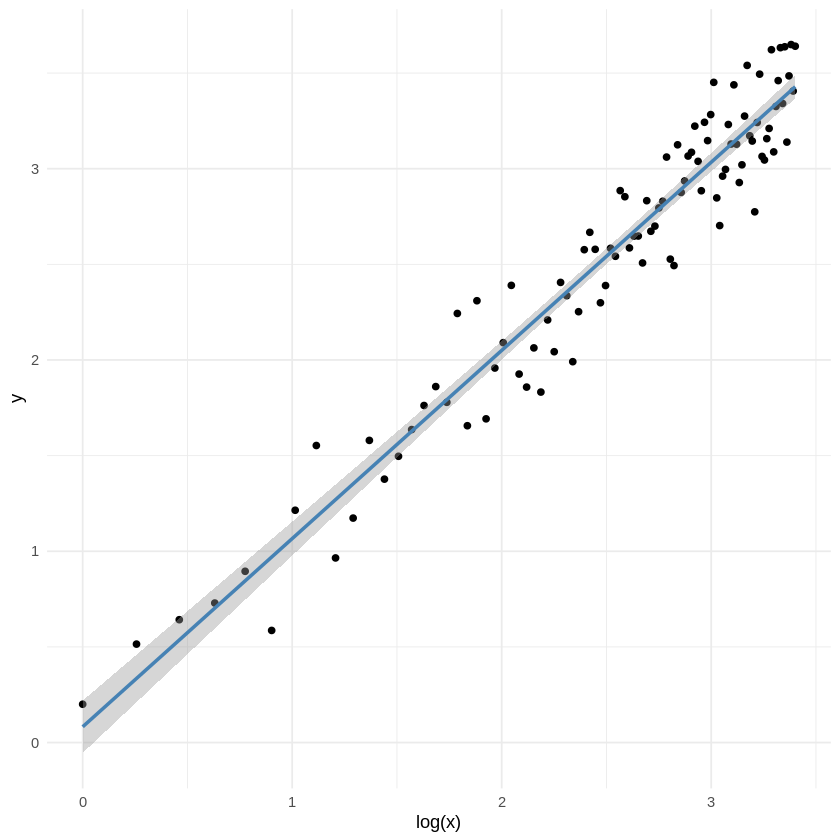

In [42]:
# Log
log_lm <- lm(y ~ log(x), data = synth)
log_lm |>
  ggplot(aes(`log(x)`, y)) +
  geom_point() +
  geom_smooth(method = "lm", color = "steelblue") +
  theme_minimal()

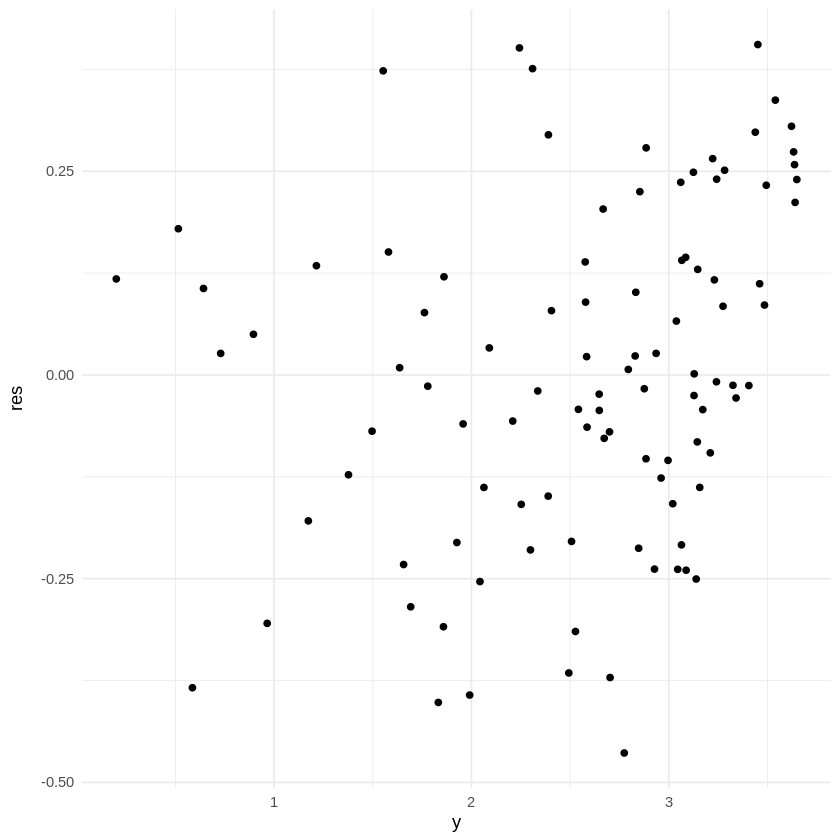

In [43]:
# Residuals
synth |>
  mutate(res = log_lm$residuals) |>
    ggplot(aes(y, res)) +
    geom_point() +
    theme_minimal()

# 2. Working with the advertising dataset

In [44]:
# Read the data
path <- kgh$dataset_download("ashydv/advertising-dataset")
advertising <- read_csv(paste0(path, "/advertising.csv"))
head(advertising)

Rows: 200 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): TV, Radio, Newspaper, Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TV,Radio,Newspaper,Sales
<dbl>,<dbl>,<dbl>,<dbl>
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,12.0
151.5,41.3,58.5,16.5
180.8,10.8,58.4,17.9
8.7,48.9,75.0,7.2


`geom_smooth()` using formula = 'y ~ x'


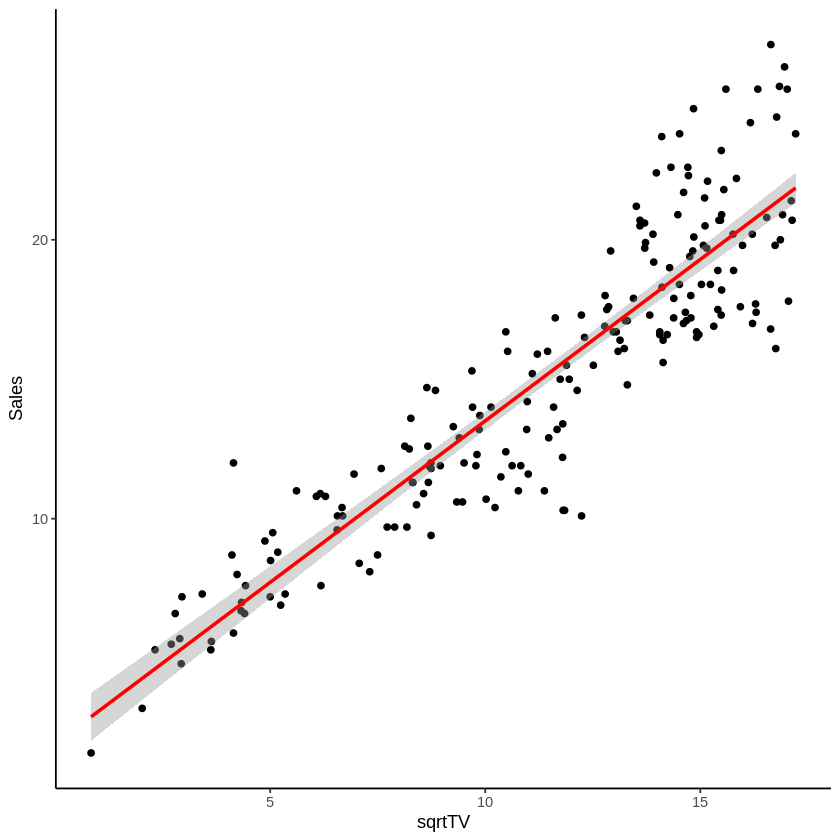

In [45]:
# transforming a variable
advertising |>
  select(Sales, TV) |>
  mutate(sqrtTV = sqrt(TV)) |>
  ggplot(aes(sqrtTV, Sales)) +
  geom_point() +
  geom_smooth(method = "lm", color = "red") +
  theme_classic()

In [46]:
# lm with transformed data
trans_lm <- lm(Sales ~ sqrt(TV), data = advertising)
summary(trans_lm)


Call:
lm(formula = Sales ~ sqrt(TV), data = advertising)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9994 -1.4295 -0.2339  1.3028  5.8050 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.92868    0.46483   4.149 4.95e-05 ***
sqrt(TV)     1.15781    0.03833  30.204  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.237 on 198 degrees of freedom
Multiple R-squared:  0.8217,	Adjusted R-squared:  0.8208 
F-statistic: 912.3 on 1 and 198 DF,  p-value: < 2.2e-16


In [47]:
# Look at the design matrix
head(model.matrix(trans_lm))

,(Intercept),sqrt(TV)
1,1,15.169047
2,1,6.670832
3,1,4.147288
4,1,12.308534
5,1,13.446189
6,1,2.949576


In [48]:
# Look at the terms
trans_lm$terms

Sales ~ sqrt(TV)
attr(,"variables")
list(Sales, sqrt(TV))
attr(,"factors")
         sqrt(TV)
Sales           0
sqrt(TV)        1
attr(,"term.labels")
[1] "sqrt(TV)"
attr(,"order")
[1] 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(Sales, sqrt(TV))
attr(,"dataClasses")
    Sales  sqrt(TV) 
"numeric" "numeric" 

# 4. Model selection

## 4.1 Look at r-square

In [49]:
# Linear regression
simple_lm <- lm(Sales ~ TV, data = advertising)
summary(simple_lm)$r.squared

[1] 0.8121757

In [50]:
# R-square of the other model
summary(trans_lm)$r.squared

[1] 0.8216696

## 4.2 F-test
Another way of comparing two models, in particular one model with a smaller nested model, is the ANOVA test, which is an instance of the F-test

In [51]:
# Linear model with multiple variables
double_lm <- lm(Sales ~ TV + Radio, data = advertising)
anova(trans_lm, double_lm)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,198,990.8008,NA,NA,NA,NA
2,197,541.2105,1,449.5903,163.6503,1.135196e-27


# 5. Qualitative predictors

In [55]:
# Generate the dataset
set.seed(41)
balls <- c(rep("A", 50), rep("B", 50), rep("C", 50), rep("D", 50))
speed <- c(rnorm(50, mean = 100, sd = 3), rnorm(50, mean = 95, sd = 3), rnorm(50, mean = 105, sd = 3), rnorm(50, mean = 100, sd = 3.5))
df <- tibble(
  Balls=balls,
  Speed=speed
)
df$Balls <- as.factor(df$Balls)
head(df)

Balls,Speed
<fct>,<dbl>
A,97.61689
A,100.59177
A,103.00511
A,103.86648
A,102.71726
A,101.48100


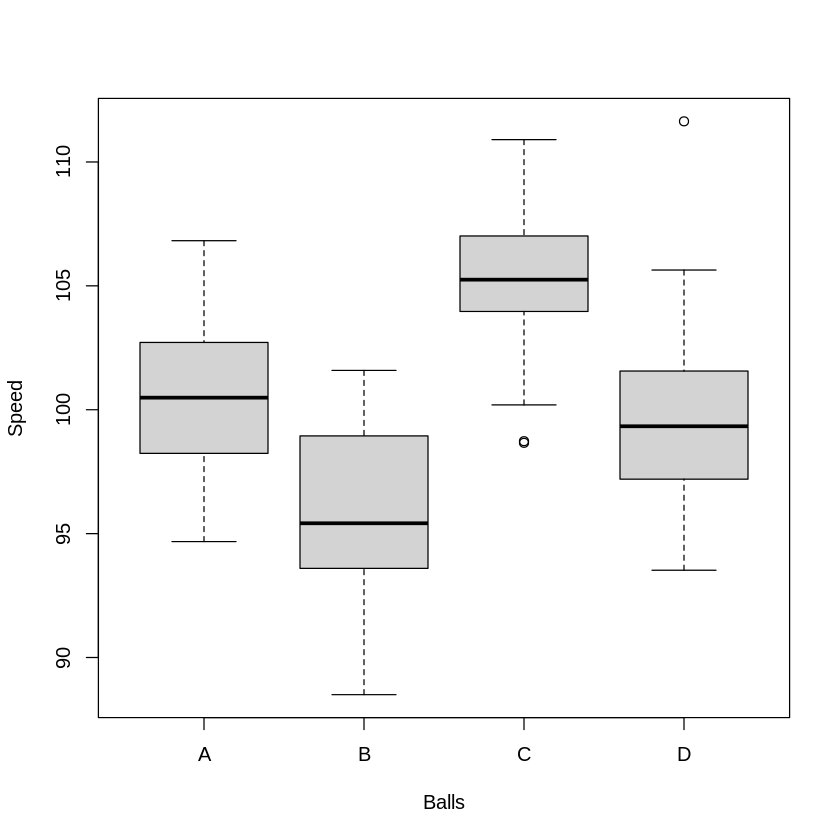

In [56]:
# Visualize
boxplot(Speed ~ Balls, data = df)

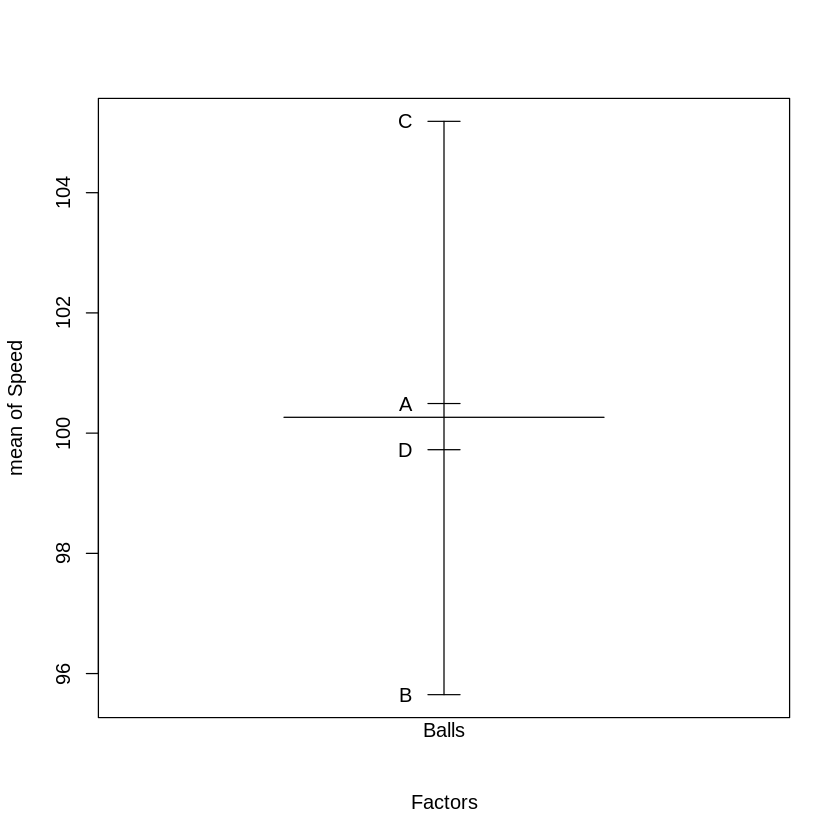

In [57]:
# Design plot
plot.design(Speed ~ Balls, data = df)

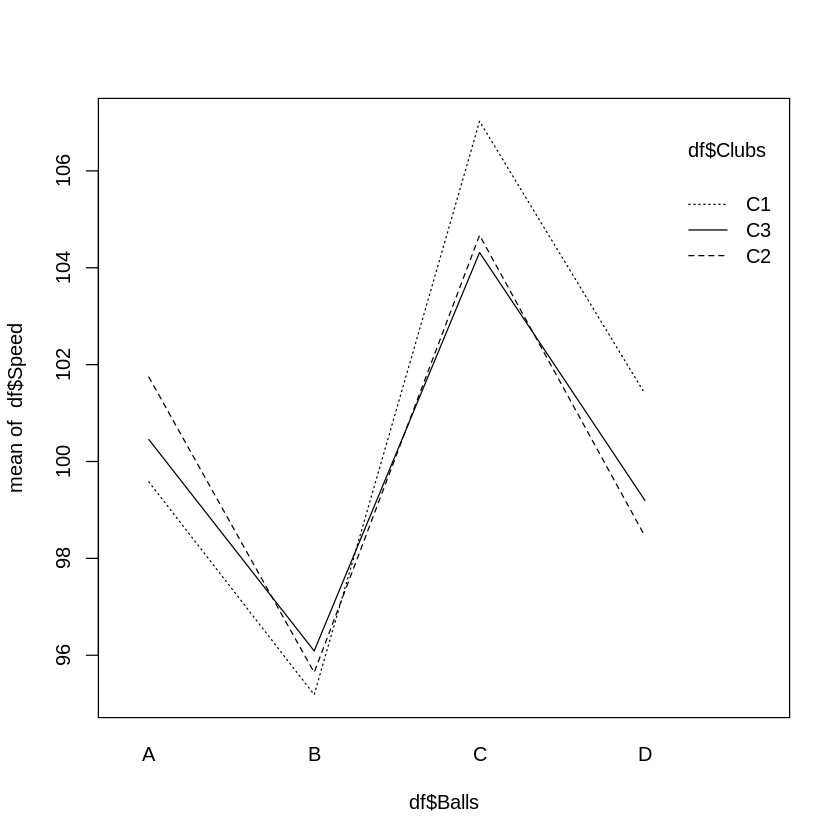

In [59]:
# Interactions
df$Clubs <- sample(c("C1", "C2", "C3"), size = 200, replace = TRUE) # create a new column
df$Clubs <- as.factor(df$Clubs)

small_lm <- lm(Speed ~ Balls + Clubs, data = df) # multiple linear regression without any interaction
large_lm <- lm(Speed ~ Balls*Clubs, data = df) # multiple linear regression with interactions

interaction.plot(df$Balls, df$Clubs, df$Speed)

In [60]:
# Compare the large model with small ones
anova(large_lm)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Balls,3,2293.66907,764.556355,85.640408,5.693654e-35
Clubs,2,24.82447,12.412235,1.390334,2.515402e-01
Balls:Clubs,6,166.22956,27.704927,3.103318,6.380704e-03
Residuals,188,1678.37353,8.927519,NA,NA


In [63]:
# ANOVA
print(anova(small_lm, large_lm))

Analysis of Variance Table

Model 1: Speed ~ Balls + Clubs
Model 2: Speed ~ Balls * Clubs
  Res.Df    RSS Df Sum of Sq      F   Pr(>F)   
1    194 1844.6                                
2    188 1678.4  6    166.23 3.1033 0.006381 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [61]:
# Fitted model
fitted(large_lm)

1         2         3         4         5         6         7         8 
101.74426  99.58002  99.58002  99.58002 100.45453 101.74426 100.45453  99.58002 
        9        10        11        12        13        14        15        16 
100.45453 101.74426  99.58002 100.45453 100.45453 100.45453  99.58002 101.74426 
       17        18        19        20        21        22        23        24 
101.74426 100.45453  99.58002 100.45453  99.58002 101.74426 100.45453  99.58002 
       25        26        27        28        29        30        31        32 
101.74426 100.45453 100.45453 100.45453 100.45453 100.45453 101.74426  99.58002 
       33        34        35        36        37        38        39        40 
100.45453 100.45453  99.58002  99.58002  99.58002 101.74426  99.58002 101.74426 
       41        42        43        44        45        46        47        48 
100.45453 101.74426  99.58002 101.74426  99.58002 101.74426 100.45453 100.45453 
       49        50        51        52        53        54        55        56 
 99.58002 100.45453  96.08870  95.64568  95.18646  96.08870  96.08870  95.64568 
       57        58        59        60        61        62        63        64 
 96.08870  95.18646  96.08870  95.64568  96.08870  95.18646  96.08870  96.08870 
       65        66        67        68        69        70        71        72 
 96.08870  96.08870  95.18646  96.08870  95.64568  95.18646  95.64568  96.08870 
       73        74        75        76        77        78        79        80 
 95.18646  95.64568  95.64568  96.08870  95.64568  96.08870  96.08870  95.64568 
       81        82        83        84        85        86        87        88 
 95.64568  96.08870  95.18646  95.18646  95.18646  95.18646  95.18646  95.18646 
       89        90        91        92        93        94        95        96 
 95.64568  95.64568  95.64568  95.64568  95.18646  95.64568  95.18646  95.64568 
       97        98        99       100       101       102       103       104 
 96.08870  95.18646  95.64568  95.18646 104.67102 107.02277 104.67102 107.02277 
      105       106       107       108       109       110       111       112 
104.31450 104.31450 107.02277 104.31450 107.02277 104.67102 104.67102 104.67102 
      113       114       115       116       117       118       119       120 
104.31450 104.31450 107.02277 104.67102 104.31450 104.31450 107.02277 107.02277 
      121       122       123       124       125       126       127       128 
104.67102 104.31450 104.31450 104.31450 104.67102 104.67102 104.67102 104.67102 
      129       130       131       132       133       134       135       136 
104.31450 107.02277 104.31450 104.67102 104.31450 107.02277 104.31450 104.31450 
      137       138       139       140       141       142       143       144 
107.02277 104.67102 104.31450 104.67102 107.02277 104.31450 107.02277 104.31450 
      145       146       147       148       149       150       151       152 
104.67102 104.31450 104.31450 104.67102 107.02277 107.02277 101.39863  99.19714 
      153       154       155       156       157       158       159       160 
101.39863  98.45996  98.45996 101.39863  99.19714  98.45996  99.19714  98.45996 
      161       162       163       164       165       166       167       168 
 99.19714  98.45996  98.45996  99.19714 101.39863  99.19714  98.45996  98.45996 
      169       170       171       172       173       174       175       176 
 98.45996 101.39863  99.19714  98.45996  99.19714  99.19714 101.39863  98.45996 
      177       178       179       180       181       182       183       184 
101.39863 101.39863  98.45996  99.19714  99.19714  98.45996  98.45996 101.39863 
      185       186       187       188       189       190       191       192 
 99.19714  98.45996 101.39863 101.39863  98.45996  98.45996 101.39863  99.19714 
      193       194       195       196       197       198       199       200 
101.39863 101.39863 101.39863  98.45996

In [64]:
# Make predictions
predict.lm(large_lm,
newdata = data.frame(
  Clubs=c("C1", "C2", "C3"),
  Balls=c("A", "A", "D")
),
inteval = "confidence"
)

1         2         3 
 99.58002 101.74426  99.19714

In [65]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] reticulate_1.43.0 lubridate_1.9.4   forcats_1.0.0     stringr_1.5.1    
 [5] dplyr_1.1.4       purrr_1.1.0       readr_2.1.5       tidyr_1.3.1      
 [9] tibble_3.3.0      gg